In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-white')

In [3]:
# Read the CSV file
df = pd.read_csv('data/events.csv', parse_dates=['event_time'])

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nMemory Usage:", df.memory_usage().sum() / 1024**2, "MB")
print("\nDataset Info:")
df.info()

Dataset Shape: (531406, 9)

Memory Usage: 36.4888801574707 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531406 entries, 0 to 531405
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     531406 non-null  datetime64[ns, UTC]
 1   event_type     531406 non-null  object             
 2   product_id     531406 non-null  int64              
 3   category_id    531406 non-null  int64              
 4   category_code  379654 non-null  object             
 5   brand          400057 non-null  object             
 6   price          531406 non-null  float64            
 7   user_id        531406 non-null  int64              
 8   user_session   531265 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 36.5+ MB


In [4]:
# Function to get unique value counts and missing values for each column
def get_column_stats(df):
    stats = pd.DataFrame({
        'Unique_Values': df.nunique(),
        'Missing_Values': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
        'Sample_Values': df.apply(lambda x: list(x.sample(min(3, len(x.unique()))).unique()))
    })
    return stats.sort_values('Unique_Values', ascending=False)

column_stats = get_column_stats(df)
print(column_stats)

               Unique_Values  Missing_Values  Missing_Percentage  \
event_time            508051               0                0.00   
user_session          305392             141                0.03   
product_id             46221               0                0.00   
price                  11683               0                0.00   
user_id                 9926               0                0.00   
brand                    970          131349               24.72   
category_code            107          151752               28.56   
event_type                 3               0                0.00   
category_id                1               0                0.00   

                                                   Sample_Values  
event_time     [2020-11-08 21:12:34+00:00, 2020-10-30 04:36:1...  
user_session   [fUItb7jpFs, 76d275cb-e171-4be9-9705-2a5d3b748...  
product_id                              [16116, 788182, 1354286]  
price                                    [312.43, 1

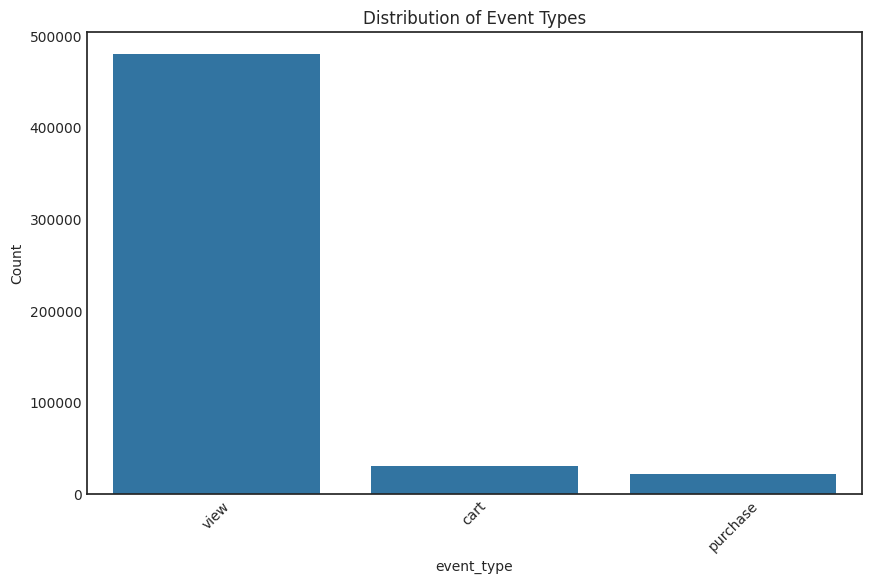

In [5]:
# 1. Event Type Distribution
plt.figure(figsize=(10, 6))
event_counts = df['event_type'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title('Distribution of Event Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

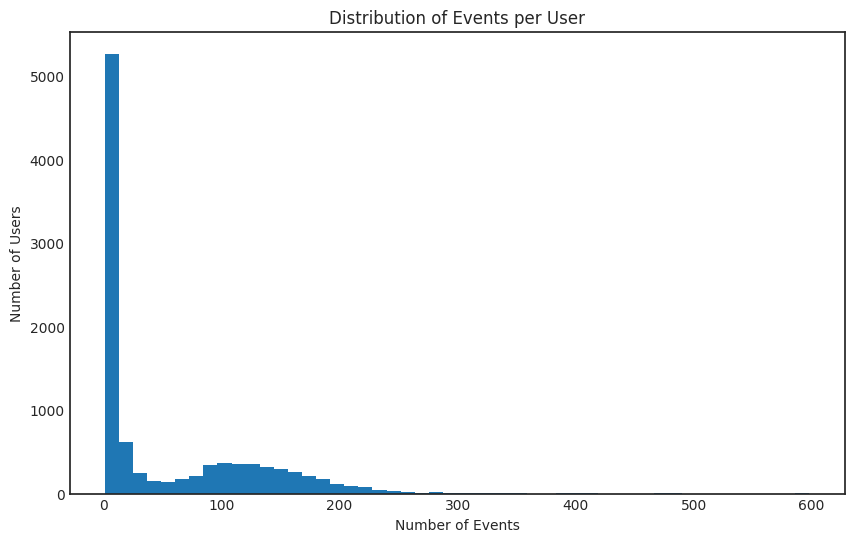

In [6]:
# 2. User Activity Analysis
user_event_counts = df.groupby('user_id')['event_type'].count()
plt.figure(figsize=(10, 6))
plt.hist(user_event_counts, bins=50)
plt.title('Distribution of Events per User')
plt.xlabel('Number of Events')
plt.ylabel('Number of Users')
plt.show()

<Figure size 1000x600 with 0 Axes>

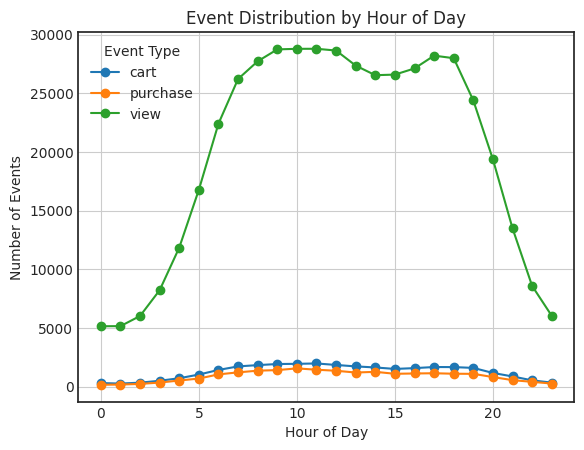

In [7]:
# 3. Time Series Analysis
df['hour'] = df['event_time'].dt.hour
hourly_events = df.groupby(['hour', 'event_type']).size().unstack()
plt.figure(figsize=(10, 6))
hourly_events.plot(kind='line', marker='o')
plt.title('Event Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.legend(title='Event Type')
plt.grid(True)
plt.show()

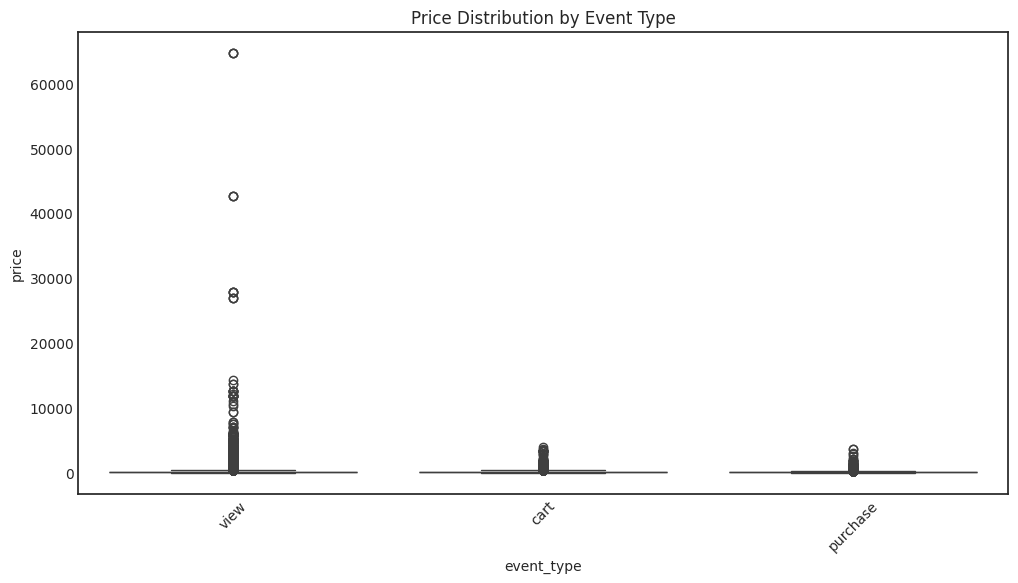

In [8]:
# 4. Price Distribution Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='event_type', y='price', data=df)
plt.title('Price Distribution by Event Type')
plt.xticks(rotation=45)
plt.show()

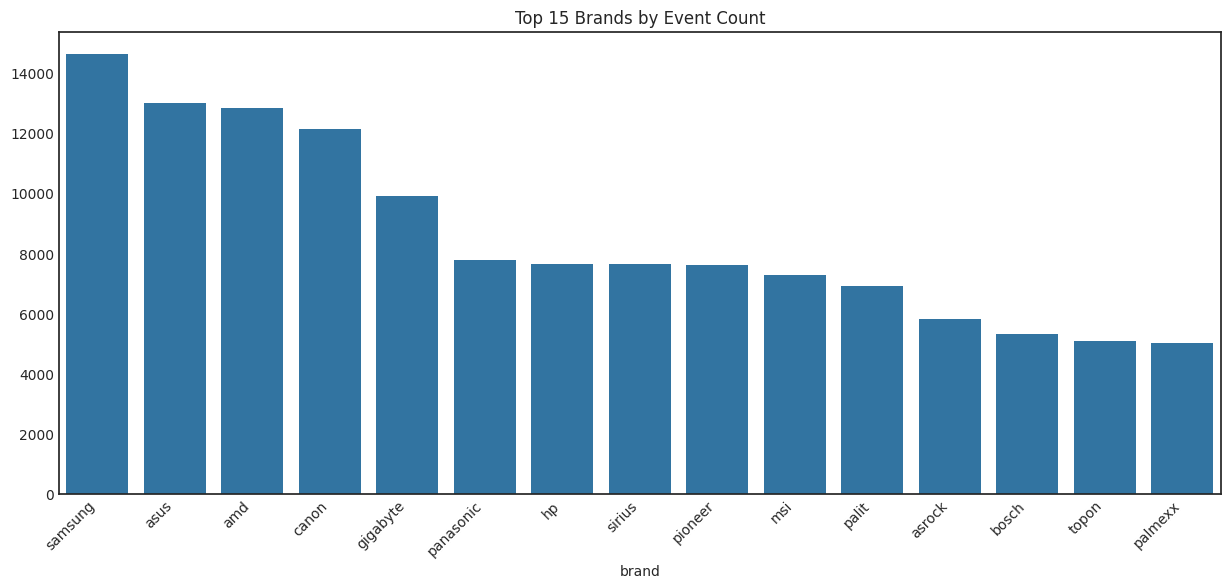

In [9]:
# 5. Brand Engagement Analysis
top_brands = df['brand'].value_counts().head(15)
plt.figure(figsize=(15, 6))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.title('Top 15 Brands by Event Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# Calculate key metrics per user
user_metrics = df.groupby('user_id').agg({
    'event_type': 'count',
    'price': ['mean', 'sum'],
    'user_session': 'nunique',
    'event_time': lambda x: (x.max() - x.min()).days
}).round(2)

user_metrics.columns = ['total_events', 'avg_price', 'total_spend', 'unique_sessions', 'days_active']

# Calculate conversion metrics
user_event_types = df.groupby(['user_id', 'event_type']).size().unstack(fill_value=0)
user_metrics = user_metrics.join(user_event_types)

# Calculate conversion rates
user_metrics['view_to_cart_rate'] = (user_metrics['cart'] / user_metrics['view']).round(3)
user_metrics['cart_to_purchase_rate'] = (user_metrics['purchase'] / user_metrics['cart']).round(3)

print("\nUser Metrics Summary:")
print(user_metrics.describe())


User Metrics Summary:
       total_events    avg_price    total_spend  unique_sessions  days_active  \
count   9926.000000  9926.000000    9926.000000      9926.000000  9926.000000   
mean      53.536772   121.660893    6690.041695        30.778360    18.264155   
std       69.041109   141.555329    9499.198184        38.982164    23.741737   
min        1.000000     0.370000       0.370000         0.000000     0.000000   
25%        2.000000    51.680000     126.075000         1.000000     0.000000   
50%       10.000000    98.890000    1093.820000         5.000000     6.000000   
75%      106.000000   142.227500   12101.927500        65.000000    33.000000   
max      598.000000  3724.830000  150861.760000       339.000000    98.000000   

              cart     purchase         view  view_to_cart_rate  \
count  9926.000000  9926.000000  9926.000000        9925.000000   
mean      3.019545     2.157465    48.359762           0.053784   
std       4.899784     3.764462    62.128065  

/home/suraj.prasad/miniconda3/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


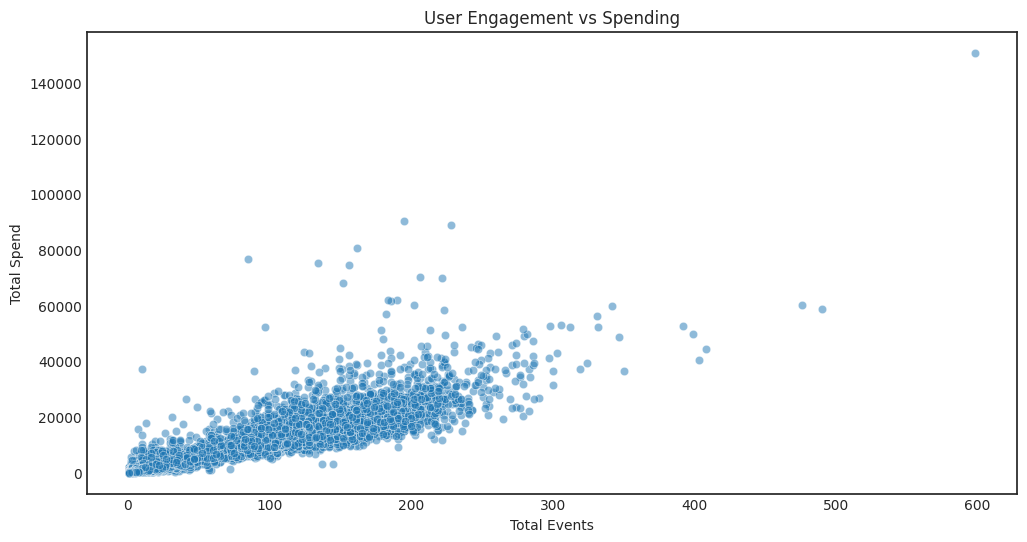

In [11]:
# User engagement patterns
plt.figure(figsize=(12, 6))
sns.scatterplot(data=user_metrics, x='total_events', y='total_spend', alpha=0.5)
plt.title('User Engagement vs Spending')
plt.xlabel('Total Events')
plt.ylabel('Total Spend')
plt.show()